In [1]:
import os
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import harmonypy as hm
from tqdm import tqdm
from scipy import sparse
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
from datetime import datetime
from anndata import read_h5ad
import anndata
from anndata import AnnData
from datetime import datetime

today_date = datetime.now().strftime('%Y%m%d')
sc.set_figure_params(facecolor="white", figsize=(8, 8))


In [2]:
f11_path = "/Users/farah/Library/CloudStorage/GoogleDrive-qianluf2@illinois.edu/My Drive/Han_lab_Drive/p5_SvsF/data/SvsF_col116/f11/f11_processed_20250727.h5ad"
s31_path = "/Users/farah/Library/CloudStorage/GoogleDrive-qianluf2@illinois.edu/My Drive/Han_lab_Drive/p5_SvsF/data/SvsF_col116/s31/s31_processed_20250727.h5ad"

f11_ad = sc.read_h5ad(f11_path)
s31_ad = sc.read_h5ad(s31_path)

In [3]:
combined_ad = anndata.concat([f11_ad, s31_ad], join="outer", label="source", keys=["f11", "s31"])

/Users/farah/anaconda3/envs/new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
combined_ad

AnnData object with n_obs × n_vars = 30217 × 140
    obs: 'size', 'total_counts', 'source', 'n_counts', 'clusters'
    obsm: 'X_pca', 'X_umap', 'spatial'

In [5]:
def apply_transformation_history(adata, csv_path, exclude_sources=None):
    """
    Apply all historical transformations from the CSV file to the AnnData object,
    excluding specified sources.
    
    Parameters:
    - adata: AnnData object containing the data
    - csv_path: Path to the transformation history CSV file
    - exclude_sources: List of source names to exclude from transformation (default: None)
    
    Returns:
    - adata: Updated AnnData object with all transformations applied
    """
    # Read the transformation history
    history = pd.read_csv(csv_path)
    
    if exclude_sources:
        history = history[~history['source'].isin(exclude_sources)]
    
    # Group by source to get unique sources
    sources = history['source'].unique()
    
    # Initialize tracker
    tracker = TransformationTracker(csv_path)
    
    # Apply transformations for each source sequentially
    for source in sources:
        source_history = history[history['source'] == source]
        
        # Apply each transformation in order
        for _, row in source_history.iterrows():
            adata = rotate_and_shift_single_source(
                adata,
                source,
                angle=row['angle'],
                shift=(row['shift_x'], row['shift_y']),
                tracker=None  # Don't track these applications as they're already in history
            )
    
    return adata

# Example usage:
def process_data_with_history(adata, csv_path):
    """
    Example workflow showing how to use the functions together.
    """
    
    # Apply all existing transformations except for s50
    adata = apply_transformation_history(adata, csv_path)
    
    # Now you can work with new data or re-transform s50
    return adata

class TransformationTracker:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        # Try to load existing transformations
        if os.path.exists(csv_path):
            self.transformations = pd.read_csv(csv_path)
            # Reconstruct cumulative data from saved transformations
            self._cumulative_data = {}
            for source in self.transformations['source'].unique():
                source_data = self.transformations[self.transformations['source'] == source].iloc[-1]
                self._cumulative_data[source] = {
                    'angle': source_data['cumulative_angle'],
                    'shift_x': source_data['cumulative_shift_x'],
                    'shift_y': source_data['cumulative_shift_y']
                }
        else:
            self.transformations = pd.DataFrame(columns=[
                'source', 'timestamp', 'angle', 'shift_x', 'shift_y',
                'cumulative_angle', 'cumulative_shift_x', 'cumulative_shift_y'
            ])
            self._cumulative_data = {}
        
    def update(self, source, angle, shift):
        timestamp = datetime.now()
        
        # Initialize cumulative tracking for new sources
        if source not in self._cumulative_data:
            self._cumulative_data[source] = {
                'angle': 0,
                'shift_x': 0,
                'shift_y': 0
            }
        
        # Update cumulative values
        self._cumulative_data[source]['angle'] += angle
        self._cumulative_data[source]['shift_x'] += shift[0]
        self._cumulative_data[source]['shift_y'] += shift[1]
        
        # Add new row to transformations DataFrame
        new_row = {
            'source': source,
            'timestamp': timestamp,
            'angle': angle,
            'shift_x': shift[0],
            'shift_y': shift[1],
            'cumulative_angle': self._cumulative_data[source]['angle'],
            'cumulative_shift_x': self._cumulative_data[source]['shift_x'],
            'cumulative_shift_y': self._cumulative_data[source]['shift_y']
        }
        
        self.transformations = pd.concat([self.transformations, 
                                        pd.DataFrame([new_row])], 
                                       ignore_index=True)
        
        # Save immediately after each update
        self.save_to_csv()
    
    def save_to_csv(self):
        self.transformations.to_csv(self.csv_path, index=False)
        
    def get_cumulative_transforms(self, source):
        if source in self._cumulative_data:
            return (self._cumulative_data[source]['angle'],
                    (self._cumulative_data[source]['shift_x'],
                     self._cumulative_data[source]['shift_y']))
        return (0, (0, 0))
    
    def print_all_transforms(self):
        for source in self._cumulative_data:
            angle, (shift_x, shift_y) = self.get_cumulative_transforms(source)
            print(f"\nSource: {source}")
            print(f"Total rotation: {angle}°")
            print(f"Total shift: (x={shift_x}, y={shift_y})")

def rotate_and_shift_single_source(adata, source, angle=0, shift=(0, 0), tracker=None):
    """
    Rotate and shift spatial coordinates of a selected source and update obsm['spatial'].
    
    Parameters:
    - adata: AnnData object containing the data.
    - source: The source label (e.g., 'CS_10') to apply the transformation to.
    - angle: The rotation angle in degrees (default is 0, meaning no rotation).
    - shift: A tuple (shift_x, shift_y) specifying the shift in x and y directions (default is (0, 0)).
    - tracker: TransformationTracker object to record transformations (optional).
    
    Returns:
    - adata: AnnData object with updated spatial coordinates in obsm['spatial'].
    """
    
    # Get the indices of cells corresponding to the selected source
    indices = adata.obs['source'] == source
    
    # Get the spatial coordinates of the selected cells
    spatial_coords = adata.obsm['spatial'][indices, :]
    
    # Convert angle to radians for rotation
    angle_rad = np.deg2rad(angle)
    
    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    # Apply the rotation matrix to the spatial coordinates
    rotated_coords = np.dot(spatial_coords, rotation_matrix.T)
    
    # Apply the shift
    shift_x, shift_y = shift
    shifted_coords = rotated_coords + np.array([shift_x, shift_y])
    
    # Update the rotated and shifted coordinates in the AnnData object
    adata.obsm['spatial'][indices, :] = shifted_coords
    
    # Track the transformation if tracker is provided
    if tracker is not None:
        tracker.update(source, angle, shift)
    
    return adata

In [ ]:
csv_path = '/Users/farah/Library/CloudStorage/GoogleDrive-qianluf2@illinois.edu/My Drive/Han_lab_Drive/p5_SvsF/code/SvsF_col116_transformation_history.csv'

# Uncheck the following lines to add the transformations to the transformation history
#tracker = TransformationTracker(csv_path) 
#combined_ad = rotate_and_shift_single_source(combined_ad, 's31', angle=0, shift=(0, 0), tracker=tracker)
#tracker.print_all_transforms()


Source: s39
Total rotation: 81°
Total shift: (x=1180, y=-5530)

Source: f11
Total rotation: -155°
Total shift: (x=0, y=0)

Source: s31
Total rotation: -133°
Total shift: (x=-1570, y=20)


/Users/farah/anaconda3/envs/new_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/Users/farah/anaconda3/envs/new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/farah/anaconda3/envs/new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


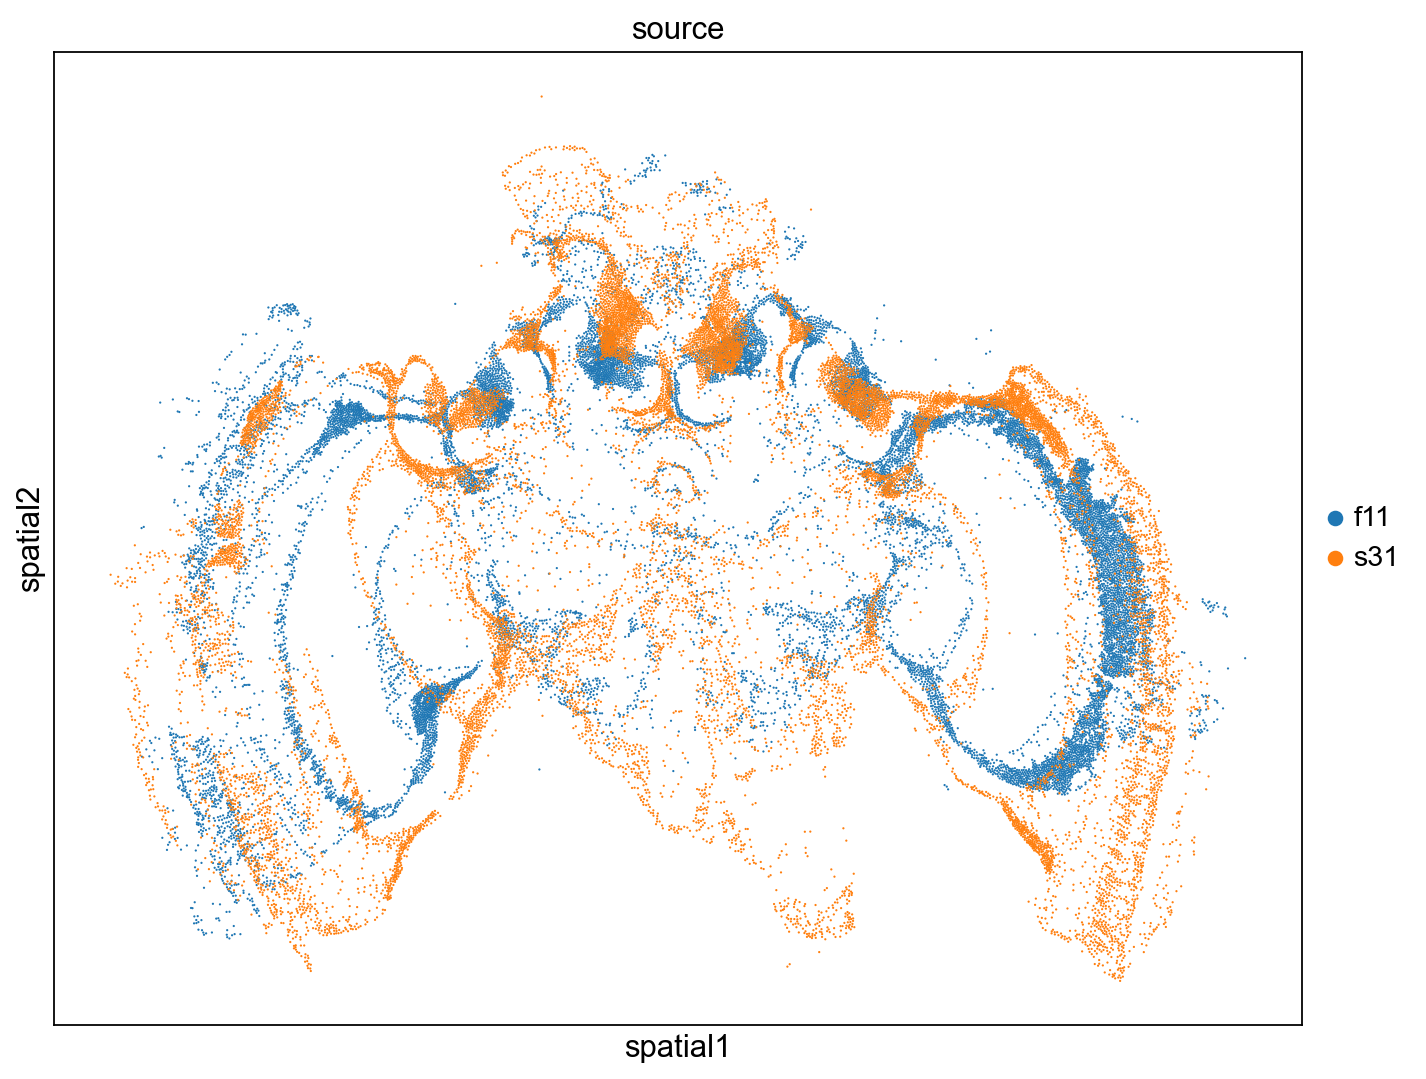

In [54]:
sc.set_figure_params(facecolor="white", figsize=(10, 8))
# For multiple sources
sc.pl.embedding(combined_ad[combined_ad.obs['source'].isin(['s31','f11'])], basis="spatial", color="source")

In [ ]:
# Uncheck the following lines to apply the transformations to the combined AnnData object
#adata_transformed = apply_transformation_history(combined_ad, csv_path)


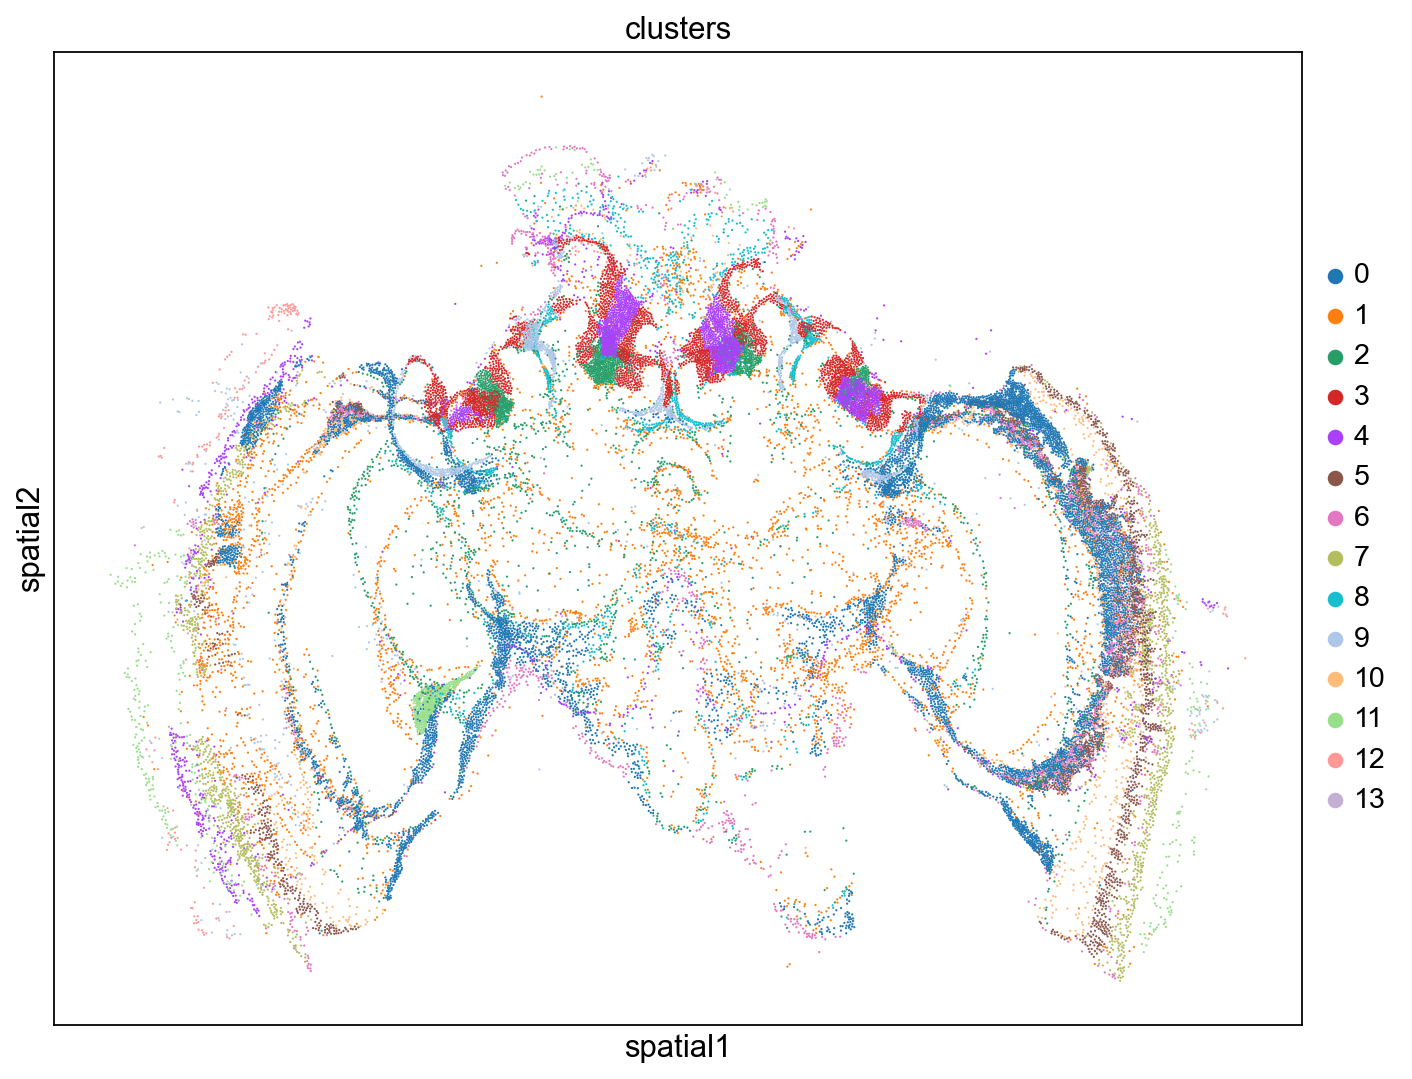

In [55]:
sc.set_figure_params(facecolor="white", figsize=(10, 8))
sc.pl.embedding(combined_ad, basis="spatial", color="clusters")

In [ ]:

output_path = (
    "/Users/farah/Library/CloudStorage/"
    "GoogleDrive-qianluf2@illinois.edu/"
    "My Drive/Han_lab_Drive/p5_SvsF/"
    "data/SvsF_col116/"
    "SvsF_col116r0.5_adata_transformed.h5ad"
)

# write the transformed AnnData to disk
combined_ad.write_h5ad(output_path)

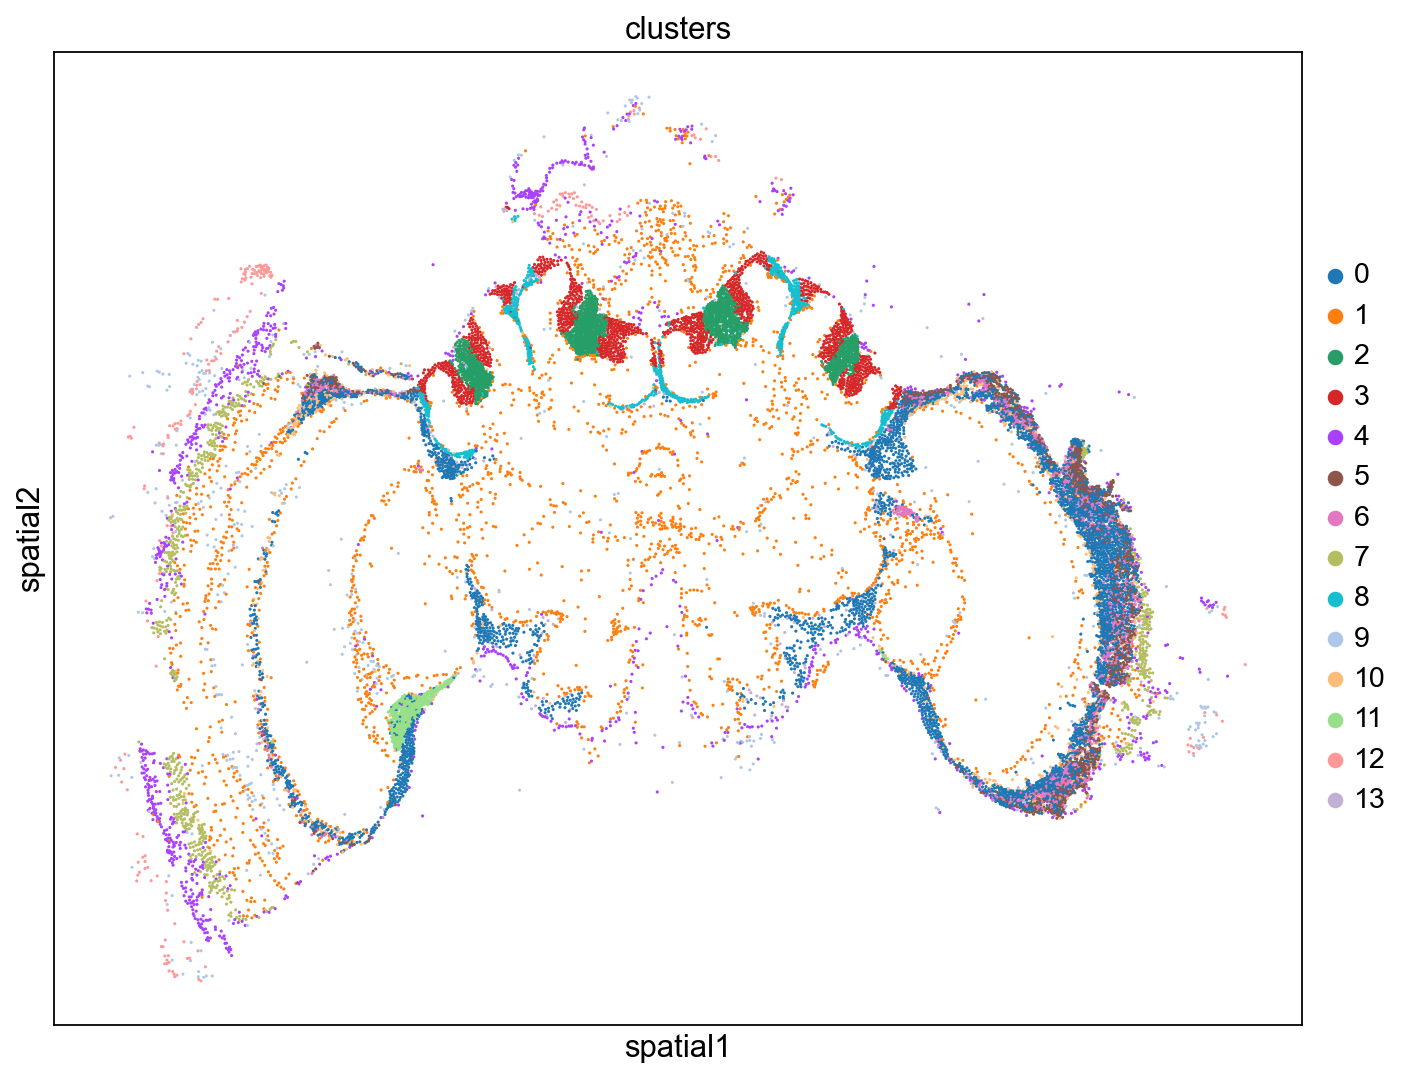

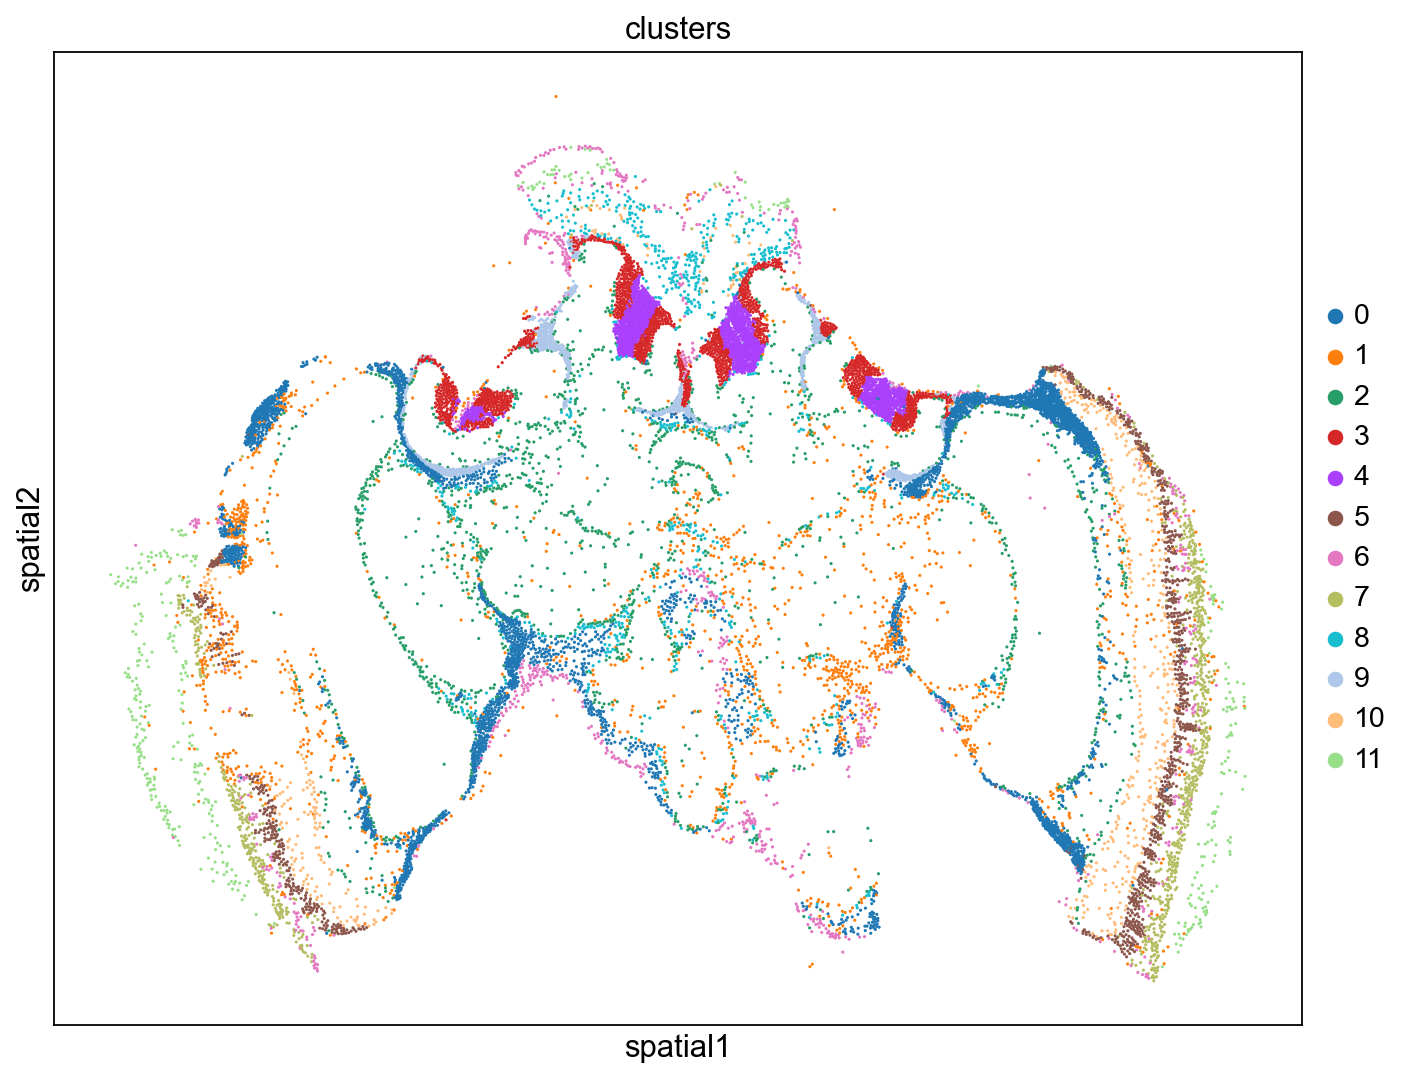

In [59]:
f11_transformed = combined_ad[combined_ad.obs['source'] == 'f11']
s31_transformed = combined_ad[combined_ad.obs['source'] == 's31']

sc.pl.embedding(f11_transformed, basis="spatial", color="clusters")
sc.pl.embedding(s31_transformed, basis="spatial", color="clusters")

In [60]:
f11_transformed.write_h5ad("/Users/farah/Library/CloudStorage/GoogleDrive-qianluf2@illinois.edu/My Drive/Han_lab_Drive/p5_SvsF/data/SvsF_col116/f11/f11_transformed.h5ad")
#s31_transformed.write_h5ad("/Users/farah/Library/CloudStorage/GoogleDrive-qianluf2@illinois.edu/My Drive/Han_lab_Drive/p5_SvsF/data/SvsF_col116/s31/s31_transformed.h5ad")